<a href="https://colab.research.google.com/github/vmanluct/BeerRatingPredictor/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict actual rating of beer reviews

In [ ]:
import numpy as np
import gzip
import math
import scipy.optimize
import json
import random
import pandas as pd
import dateutil.parser
import datetime
import time
import string
import nltk
nltk.download('stopwords')
from urllib.request import urlopen
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from decimal import Decimal, ROUND_DOWN, ROUND_UP
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)
data = list(parseData("http://cseweb.ucsd.edu/classes/fa19/cse258-a/data/beer_50000.json"))
data[0]

{'beer/ABV': 5.0,
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'beer/name': 'Sausa Weizen',
 'beer/style': 'Hefeweizen',
 'review/appearance': 2.5,
 'review/aroma': 2.0,
 'review/overall': 1.5,
 'review/palate': 1.5,
 'review/taste': 1.5,
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.',
 'review/timeStruct': {'hour': 20,
  'isdst': 0,
  'mday': 16,
  'min': 57,
  'mon': 2,
  'sec': 3,
  'wday': 0,
  'yday': 47,
  'year': 2009},
 'review/timeUnix': 1234817823,
 'user/profileName': 'stcules'}

In [ ]:
beerPerUser = defaultdict(set)
userPerBeer = defaultdict(set)
ratingDict = {}

for d in data:
  user,beer = d['user/profileName'], d['beer/beerId']
  beerPerUser[user].add(beer)
  userPerBeer[beer].add(user)
  ratingDict[(user,beer)] = d['review/overall']

In [ ]:
ratings = []
for d in data:
  ratings.append(d['review/overall'])

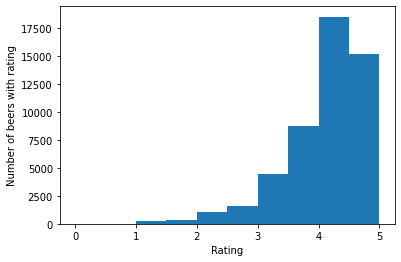

In [ ]:
plt.hist(ratings)
plt.xlabel('Rating')
plt.ylabel('Number of beers with rating')
plt.show()

In [ ]:
abv = []
for d in data:
  abv.append(d['beer/ABV'])

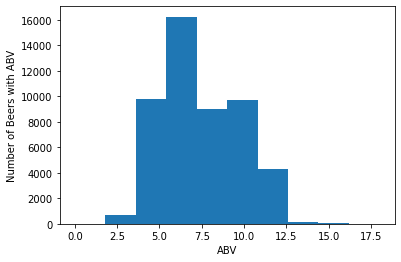

In [ ]:
plt.hist(abv, range=[0,18])
plt.xlabel('ABV')
plt.ylabel('Number of Beers with ABV')
plt.show()

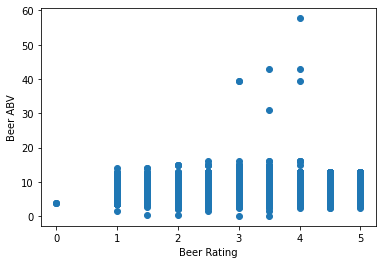

In [ ]:
plt.scatter(ratings, abv)
plt.xlabel('Beer Rating')
plt.ylabel('Beer ABV')
plt.show()

In [ ]:
ratingsTimeHour = []
for d in data:
  ratingsTimeHour.append((d['review/timeStruct']['hour'], d['review/overall']))

In [ ]:
ratingsTimeHour.sort()

In [ ]:
avgRatingsForHour = []
length = 0
total = 0
currDay = 0
for r in ratingsTimeHour:
  if r[0] == currDay:
    total += r[1]
    length += 1
  else:
    avgRatingsForHour.append(total/length)
    total = 0
    length = 0
    total += r[1]
    length += 1
    currDay = r[0]

In [ ]:
hour = list(range(1,24))

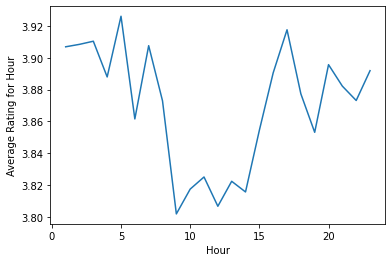

In [ ]:
plt.plot(hour,avgRatingsForHour)
plt.xlabel('Hour')
plt.ylabel('Average Rating for Hour')
plt.show()

In [ ]:
ratingsMon = []
for d in data:
  ratingsMon.append((d['review/timeStruct']['mon'], d['review/overall']))
ratingsMon.sort()

In [ ]:
avgRatingsForMon = []
length = 0
total = 0
curr = 1
for r in ratingsMon:
  if r[0] == curr:
    total += r[1]
    length += 1
  else:
    avgRatingsForMon.append(total/length)
    total = 0
    length = 0
    total += r[1]
    length += 1
    curr = r[0]
avgRatingsForMon.append(total/length)

In [ ]:
avgRatingsForMon

[3.9139599170697994,
 3.909901517167953,
 3.916323731138546,
 3.9073110285006196,
 3.90002462447673,
 3.868933333333333,
 3.838857284194905,
 3.858581128541325,
 3.862668298653611,
 3.93701399688958,
 3.869166289080199,
 3.876945970695971]

In [ ]:
months = list(range(1,13))

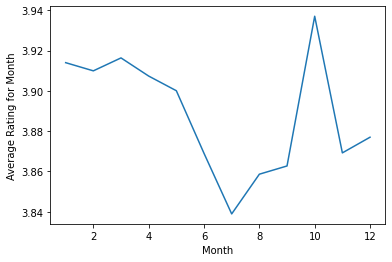

In [ ]:
plt.plot(months, avgRatingsForMon)
plt.xlabel('Month')
plt.ylabel('Average Rating for Month')
plt.show()

In [ ]:
userAverages = {}
itemAverages = {}

for u in beerPerUser:
  rs = [ratingDict[(u,i)] for i in beerPerUser[u]]
  userAverages[u] = sum(rs) / len(rs)
    
for i in userPerBeer:
  rs = [ratingDict[(u,i)] for u in userPerBeer[i]]
  itemAverages[i] = sum(rs) / len(rs)

In [ ]:
def PearsonUser(u1, u2):
  uBar1 = userAverages[u1]
  uBar2 = userAverages[u2]
  inter = beerPerUser[u1].intersection(beerPerUser[u2])
  numer = 0
  denom1 = 0
  denom2 = 0
  for i in inter:
    numer += (ratingDict[(u1, i)] - uBar1)*(ratingDict[(u2, i)] - uBar2)
  for i in inter:
    denom1 += (ratingDict[(u1,i)] - uBar1)**2
    denom2 += (ratingDict[(u2,i)] - uBar2)**2
  denom = math.sqrt(denom1)*math.sqrt(denom2)
  if denom == 0: return 0
  return numer/denom

In [ ]:
def PearsonBeer(i1, i2):
  iBar1 = itemAverages[i1]
  iBar2 = itemAverages[i2]
  inter = userPerBeer[i1].intersection(userPerBeer[i2])
  numer = 0
  denom1 = 0
  denom2 = 0
  for i in inter:
    numer += (ratingDict[(i,i1)] - iBar1)*(ratingDict[(i,i2)] - iBar2)
  for i in inter:
    denom1 += (ratingDict[(i,i1)] - iBar1)**2
    denom2 += (ratingDict[(i,i2)] - iBar2)**2
  denom = math.sqrt(denom1)*math.sqrt(denom2)
  if denom == 0: return 1
  return numer/denom

In [ ]:
for d in data:
  if d['user/profileName'] == '47986':
    print('Here')

In [ ]:
ratingAverage = 0
for d in data[:40000]:
  ratingAverage += d['review/overall']
ratingAverage /= len(data[:40000])

In [ ]:
avgPredict = [ratingAverage]*len(data[40000:])
yAvgTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
avgMSE = np.square(np.subtract(yAvgTest, avgPredict)).mean()
avgMSE 

0.47763178000000006

In [ ]:
def hourFeature(datum):
  feat = [1]
  feat.append(datum['review/timeStruct']['hour'])
  return feat

In [ ]:
XhourTrain = [hourFeature(d) for d in data[:40000]]
yHourTrain = [d['review/overall'] for d in data[:40000]]
XhourTest = [hourFeature(d) for d in data[40000:]]
yHourTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
hourMod = linear_model.LinearRegression()
hourMod.fit(XhourTrain,yHourTrain)

LinearRegression()

In [ ]:
hourPred = hourMod.predict(XhourTest)

In [ ]:
hourMSE = np.square(np.subtract(yHourTest, hourPred)).mean()
hourMSE

0.47766624419438686

In [ ]:
def oneHotHourFeat(datum):
  feat = [0]*24
  feat.append(1)
  feat[datum['review/timeStruct']['hour']] = 1
  return feat

In [ ]:
XhourTrain = [oneHotHourFeat(d) for d in data[:40000]]
yHourTrain = [d['review/overall'] for d in data[:40000]]
XhourTest = [oneHotHourFeat(d) for d in data[40000:]]
yHourTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
hourMod = linear_model.LinearRegression()
hourMod.fit(XhourTrain,yHourTrain)

LinearRegression()

In [ ]:
hourPred = hourMod.predict(XhourTest)

In [ ]:
hourMSE = np.square(np.subtract(yHourTest, hourPred)).mean()
hourMSE

0.47885790643692017

In [ ]:
def monthFeature(datum):
  feat = [1]
  feat.append(datum['review/timeStruct']['mon'])
  return feat

In [ ]:
XmonthTrain = [monthFeature(d) for d in data[:40000]]
yMonthTrain = [d['review/overall'] for d in data[:40000]]
XmonthTest = [monthFeature(d) for d in data[40000:]]
yMonthTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
monMod = linear_model.LinearRegression()
monMod.fit(XmonthTrain, yMonthTrain)

LinearRegression()

In [ ]:
monPred = monMod.predict(XmonthTest)

In [ ]:
monMSE = np.square(np.subtract(yMonthTest, monPred)).mean()
monMSE

0.47756261241443754

In [ ]:
def oneHotMonthFeat(datum):
  feat = [0]*12
  feat.append(1)
  feat[datum['review/timeStruct']['mon']-1] = 1
  return feat

In [ ]:
XmonthTrain = [oneHotMonthFeat(d) for d in data[:40000]]
yMonthTrain = [d['review/overall'] for d in data[:40000]]
XmonthTest = [oneHotMonthFeat(d) for d in data[40000:]]
yMonthTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
monMod = linear_model.LinearRegression()
monMod.fit(XmonthTrain, yMonthTrain)

LinearRegression()

In [ ]:
monPred = monMod.predict(XmonthTest)

In [ ]:
monMSE = np.square(np.subtract(yMonthTest, monPred)).mean()
monMSE

0.47877718801498415

In [ ]:
def monthHourFeat(datum):
  feat = [1]
  feat.append(datum['review/timeStruct']['hour'])
  feat.append(datum['review/timeStruct']['mon'])
  return feat

In [ ]:
XbothTrain = [monthHourFeat(d) for d in data[:40000]]
XbothTest = [monthHourFeat(d) for d in data[40000:]]
yBothTrain = [d['review/overall'] for d in data[:40000]]
yBothTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
bothMod = linear_model.LinearRegression()
bothMod.fit(XbothTrain,yBothTrain)

LinearRegression()

In [ ]:
bothPred = bothMod.predict(XbothTest)

In [ ]:
bothMSE = np.square(np.subtract(yBothTest,bothPred)).mean()
bothMSE

0.4775973594442433

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  for w in r.split():
    wordCount[w] += 1

In [ ]:
sortWords = sorted(wordCount.items(), key=lambda x:x[1], reverse=True)

In [ ]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

In [ ]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [ ]:
def BOWFeature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [ ]:
XBOWTrain = [BOWFeature(d) for d in data[:40000]]
XBOWTest = [BOWFeature(d) for d in data[40000:]]
yBOWTrain = [d['review/overall'] for d in data[:40000]]
yBOWTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
BOWMod = linear_model.LinearRegression()
BOWMod.fit(XBOWTrain, yBOWTrain)

LinearRegression()

In [ ]:
BOWPred = BOWMod.predict(XBOWTest)

In [ ]:
BOWMSE = np.square(np.subtract(yBOWTest,BOWPred)).mean()
BOWMSE

0.35394079867295425

In [ ]:
def CosineByBeer(i1,i2):
  inter = userPerBeer[i1].intersection(userPerBeer[i2])
  numer = 0
  denom1 = 0
  denom2 = 0
  for u in inter:
    numer += ratingDict[u,i1]*ratingDict[u,i2]
  for u in userPerBeer[i1]:
    denom1 += ratingDict[u,i1]**2
  for u in userPerBeer[i2]:
    denom2 += ratingDict[u,i2]**2
  denom = math.sqrt(denom1)*math.sqrt(denom2)
  if denom == 0: return 0
  return numer/denom

In [ ]:
def CosineByUser(u1,u2):
  inter = beerPerUser[u1].intersection(beerPerUser[u2])
  numer = 0
  denom1 = 0
  denom2 = 0
  for i in inter:
    numer += ratingDict[u1,i]*ratingDict[u2,i]
  for i in beerPerUser[u1]:
    denom1 += ratingDict[u1,i]**2
  for i in beerPerUser[u2]:
    denom2 += ratingDict[u2,i]**2
  denom = math.sqrt(denom1)*math.sqrt(denom2)
  if denom == 0: return 0
  return numer/denom

In [ ]:
def predictRatingUserSim(user, item):
  rate = []
  sims = []
  for d in userPerBeer[item]:
    i2 = d
    if i2 == item: continue
    rate.append(ratingDict[(i2,item)] - userAverages[i2])
    sims.append(CosineByUser(user,i2))
  if sum(sims) > 0:
    weightedRatings = [(x*y) for x,y in zip(rate,sims)]
    return userAverages[user] + sum(weightedRatings) / sum(sims)
  else: 
    return ratingAverage

In [ ]:
def predictRatingBeerSim(user, item):
  rate = []
  sims = []
  for d in beerPerUser[user]:
    i2 = d
    if i2 == item: continue
    rate.append(ratingDict[(user,i2)] - itemAverages[i2])
    sims.append(CosineByBeer(item,i2))
  if sum(sims) > 0:
    weightedRatings = [(x*y) for x,y in zip(rate,sims)]
    return itemAverages[item] + sum(weightedRatings) / sum(sims)
  else: 
    return ratingAverage

In [ ]:
CosineBeerPreds = [predictRatingBeerSim(d['user/profileName'], d['beer/beerId']) for d in data[40000:]]

In [ ]:
yTest = [d['review/overall'] for d in data[40000:]]

In [ ]:
pMSE = np.square(np.subtract(yTest, CosineBeerPreds)).mean()
pMSE

0.4170239163638366

In [ ]:
CosineUserPreds = [predictRatingUserSim(d['user/profileName'], d['beer/beerId']) for d in data[40000:]]

In [ ]:
cMSE = np.square(np.subtract(yTest,CosineUserPreds)).mean()
cMSE

0.25378488632690543

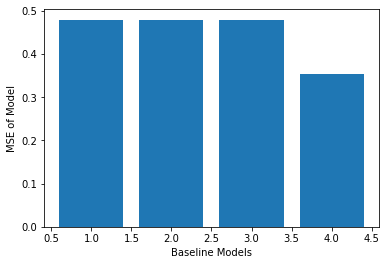

In [ ]:
baselineNames = [1,2,3,4]
baselineMSE = [avgMSE, hourMSE, monMSE, BOWMSE]
plt.bar(baselineNames, baselineMSE)
plt.xlabel('Baseline Models')
plt.ylabel('MSE of Model')
plt.show()

In [ ]:
baselineMSE

[0.47763178000000006,
 0.47885790643692017,
 0.47877718801498415,
 0.35394079867295425]

In [ ]:
ratingAverage

3.9021

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stopwords = stopwords.words('english')

In [ ]:
posWordCount = defaultdict(int)
negWordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  for w in r.split():
    if d['review/overall'] > ratingAverage and not w in stopwords:
      posWordCount[w] += 1
    elif not w in stopwords:
      negWordCount[w] += 1

In [ ]:
posBiGramCount = defaultdict(int)
negBiGramCount = defaultdict(int)
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  ws = r.split()
  for w in ws:
    if w in stopwords:
      ws.remove(w)
  ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
  for w in ws + ws2:
    if d['review/overall'] > ratingAverage:
      posBiGramCount[w] += 1
    else:
      negBiGramCount[w] += 1

In [ ]:
posBiCounts = [(posBiGramCount[w],w) for w in posBiGramCount]
negBiCounts = [(negBiGramCount[w],w) for w in negBiGramCount]
posBiCounts.sort()
negBiCounts.sort()
posBiCounts.reverse()
negBiCounts.reverse()

In [ ]:
posBiWords = [x[1] for x in posBiCounts[:1000]]
negBiWords = [x[1] for x in negBiCounts[:1000]]

In [ ]:
posSortWords = sorted(posWordCount.items(), key=lambda x:x[1], reverse=True)
negSortWords = sorted(negWordCount.items(), key=lambda x:x[1], reverse=True)

In [ ]:
posCounts = [(posWordCount[w], w) for w in posWordCount]
posCounts.sort()
posCounts.reverse()
posWords = [x[1] for x in posCounts[:1000]]
negCounts = [(negWordCount[w], w) for w in negWordCount]
negCounts.sort()
negCounts.reverse()
negWords = [x[1] for x in negCounts[:1000]]

In [ ]:
data[0]

{'beer/ABV': 5.0,
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'beer/name': 'Sausa Weizen',
 'beer/style': 'Hefeweizen',
 'review/appearance': 2.5,
 'review/aroma': 2.0,
 'review/overall': 1.5,
 'review/palate': 1.5,
 'review/taste': 1.5,
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.',
 'review/timeStruct': {'hour': 20,
  'isdst': 0,
  'mday': 16,
  'min': 57,
  'mon': 2,
  'sec': 3,
  'wday': 0,
  'yday': 47,
  'year': 2009},
 'review/timeUnix': 1234817823,
 'user/profileName': 'stcules'}

In [ ]:
monthAvgDiff = []
for a in avgRatingsForMon:
  monthAvgDiff.append(a-ratingAverage)

In [ ]:
monthAvgDiff

[0.011859917069799497,
 0.007801517167953076,
 0.014223731138546025,
 0.005211028500619719,
 -0.0020753755232698623,
 -0.03316666666666679,
 -0.063242715805095,
 -0.043518871458674724,
 -0.03943170134638896,
 0.03491399688958019,
 -0.032933710919800685,
 -0.025154029304029102]

In [ ]:
def howPositiveIsRating(datum):
  positive = 0
  negative = 0
  r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
  for w in r.split():
    if w in posBiWords and not w in negBiWords:
      positive += 1
    elif w in negBiWords and not w in posBiWords:
      negative += 1
  return (positive-negative)/len(d['review/text'])

In [ ]:
def predictor(datum):
  rate = []
  sims = []
  month = datum['review/timeStruct']['mon']
  user = datum['user/profileName']
  item = datum['beer/beerId']
  monAvg = monthAvgDiff[month-1]**2
  pos = howPositiveIsRating(datum)*20
  for d in userPerBeer[item]:
    i2 = d
    if i2 == item: continue
    rate.append(ratingDict[(i2,item)] - userAverages[i2])
    sims.append(CosineByUser(user,i2))
  if sum(sims) > 0:
    weightedRatings = [(x*y) for x,y in zip(rate,sims)]
    return (userAverages[user] + sum(weightedRatings) / sum(sims)) + pos + monAvg
  else: 
    return monthAvgDiff[month-1] + pos

In [ ]:
mainPreds = [predictor(d) for d in data[40000:]]
yMain = [d['review/overall'] for d in data[40000:]]

In [ ]:
mainMSE = np.square(np.subtract(yMain,mainPreds)).mean()
mainMSE

0.24433008035688553

0.2443

In [ ]:
for d in data:
  i = int(d['review/overall'])
  j = d['review/overall'] - i
  j *= 10
  if j != 0.0 and j != 5.0:
    print('true')

In [ ]:
test = Decimal(3.6).quantize(Decimal('0'))
test

Decimal('4')